# Image classification with Vision Transformer

**Author:** [Khalid Salama](https://www.linkedin.com/in/khalid-salama-24403144/)<br>
**Date created:** 2021/01/18<br>
**Last modified:** 2021/01/18<br>
**Description:** Implementing the Vision Transformer (ViT) model for image classification.

## Introduction

This example implements the [Vision Transformer (ViT)](https://arxiv.org/abs/2010.11929)
model by Alexey Dosovitskiy et al. for image classification,
and demonstrates it on the CIFAR-100 dataset.
The ViT model applies the Transformer architecture with self-attention to sequences of
image patches, without using convolution layers.

This example requires TensorFlow 2.4 or higher, as well as
[TensorFlow Addons](https://www.tensorflow.org/addons/overview),
which can be installed using the following command:

```python
pip install -U tensorflow-addons
```

In [ ]:
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 14.6 MB/s 


In [ ]:
!pip install tensorflow
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Setup

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow import keras
# import tensorflow_addons as tfa
import os
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATADIR = '/content/drive/MyDrive/CI7000/CI7000_Project_Dissertation/datasets'

In [ ]:
mat = scipy.io.loadmat(os.path.join(DATADIR, 'celebrity2000_meta.mat'))
age, identity, year, feature_1, feature_2, feature_3, feature_4, name = mat['celebrityImageData'][0][0]
metadata_CACD = pd.DataFrame(np.vstack([age.flatten(), identity.flatten(), year.flatten(), 
                            np.array(list(map(lambda x: x.tolist()[0][0].split("_")[1] + "_" + x.tolist()[0][0].split("_")[2], name))), 
                            np.array(list(map(lambda x: x.tolist()[0][0], name)))]).T, 
                  columns=['age', 'identity', 'year', 'name', 'filename'])
metadata_CACD['age'] = metadata_CACD['age'].astype(int)
metadata_CACD['identity'] = metadata_CACD['identity'].astype(str)
metadata_CACD['year'] = metadata_CACD['year'].astype(int)
metadata_CACD = metadata_CACD.sort_values(by=['identity', 'age'])
metadata_CACD = metadata_CACD.loc[(metadata_CACD['identity'].astype(int) >= 1) & (metadata_CACD['identity'].astype(int) <= 435)]
metadata_CACD

,age,identity,year,name,filename
0,53,1,2004,Robin_Williams,53_Robin_Williams_0001.jpg
1,53,1,2004,Robin_Williams,53_Robin_Williams_0002.jpg
2,53,1,2004,Robin_Williams,53_Robin_Williams_0003.jpg
3,53,1,2004,Robin_Williams,53_Robin_Williams_0004.jpg
4,53,1,2004,Robin_Williams,53_Robin_Williams_0005.jpg
...,...,...,...,...,...
7222,61,99,2013,Roberto_Benigni,61_Roberto_Benigni_0009.jpg
7223,61,99,2013,Roberto_Benigni,61_Roberto_Benigni_0010.jpg
7224,61,99,2013,Roberto_Benigni,61_Roberto_Benigni_0011.jpg
7225,61,99,2013,Roberto_Benigni,61_Roberto_Benigni_0012.jpg


In [ ]:
metadata_CACD = pd.DataFrame(np.vstack([age.flatten(), identity.flatten(), year.flatten(), 
                            np.array(list(map(lambda x: x.tolist()[0][0].split("_")[1] + "_" + x.tolist()[0][0].split("_")[2], name))), 
                            np.array(list(map(lambda x: x.tolist()[0][0], name)))]).T, 
                  columns=['age', 'identity', 'year', 'name', 'filename'])
metadata_CACD['age'] = metadata_CACD['age'].astype(int)
metadata_CACD['identity'] = metadata_CACD['identity'].astype(str)
metadata_CACD['year'] = metadata_CACD['year'].astype(int)
metadata_CACD = metadata_CACD.sort_values(by=['identity', 'age'])
testing_CACD = metadata_CACD.loc[(metadata_CACD['identity'].astype(int) >= 436) & (metadata_CACD['identity'].astype(int) <= 870)]
testing_CACD

,age,identity,year,name,filename
32015,45,436,2004,Mare_Winningham,45_Mare_Winningham_0001.jpg
32016,45,436,2004,Mare_Winningham,45_Mare_Winningham_0002.jpg
32017,45,436,2004,Mare_Winningham,45_Mare_Winningham_0008.jpg
32018,46,436,2005,Mare_Winningham,46_Mare_Winningham_0004.jpg
32019,46,436,2005,Mare_Winningham,46_Mare_Winningham_0012.jpg
...,...,...,...,...,...
67274,45,870,2013,Josh_Brolin,45_Josh_Brolin_0013.jpg
67275,45,870,2013,Josh_Brolin,45_Josh_Brolin_0014.jpg
67276,45,870,2013,Josh_Brolin,45_Josh_Brolin_0015.jpg
67277,45,870,2013,Josh_Brolin,45_Josh_Brolin_0016.jpg


In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 36  # Size of the patches to be extract from the input images
stride_size = 12
num_patches = 16
projection_dim = 128
num_heads = 8
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [256, 128]  # Size of the dense layers of the final classifier


In [ ]:
def prewhiten(x):
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        raise ValueError('Dimension should be 3 or 4')

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (x - mean) / std_adj
    return y

def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

def preprocess_data_facenet_without_aging(X_train):
  X_train = X_train.astype('float32')

  # X_train -= 127.5
  X_train /= 255

  return X_train

augmentation_generator = ImageDataGenerator(horizontal_flip=False, # Randomly flip images
                                    vertical_flip=False, # Randomly flip images
                                    rotation_range = None, 
                                    validation_split=0.3,
                                    brightness_range=None,
                                    preprocessing_function=preprocess_data_facenet_without_aging) #Randomly rotate

train_iterator = augmentation_generator.flow_from_dataframe(metadata_CACD, directory=os.path.join(DATADIR, "CACD2000", "CACD2000"), x_col='filename', y_col='identity', class_mode='categorical', 
                                        target_size=(image_size,image_size), color_mode='rgb', batch_size=batch_size, shuffle=False, subset='training')

validation_iterator = augmentation_generator.flow_from_dataframe(metadata_CACD, directory=os.path.join(DATADIR, "CACD2000", "CACD2000"), x_col='filename', y_col='identity', class_mode='categorical', 
                                        target_size=(image_size,image_size), color_mode='rgb', batch_size=batch_size, shuffle=False, subset='validation')
validation_gen = augmentation_generator.flow_from_dataframe(metadata_CACD, directory=os.path.join(DATADIR, "CACD2000", "CACD2000"), x_col='filename', y_col=['identity', 'name'], class_mode='raw', 
                                        target_size=(image_size,image_size), color_mode='rgb', batch_size=batch_size, shuffle=False, subset='validation')
training_gen = augmentation_generator.flow_from_dataframe(metadata_CACD, directory=os.path.join(DATADIR, "CACD2000", "CACD2000"), x_col='filename', y_col=['identity', 'name'], class_mode='raw', 
                                        target_size=(image_size,image_size), color_mode='rgb', batch_size=batch_size, shuffle=False, subset='training')

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 22963 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 6337 validated image filenames belonging to 435 classes.
Found 2715 validated image filenames belonging to 435 classes.
Found 2715 validated image filenames.
Found 6337 validated image filenames.


In [ ]:
augmentation_generator = ImageDataGenerator(horizontal_flip=False, # Randomly flip images
                                    vertical_flip=False, # Randomly flip images
                                    rotation_range = None, 
                                    validation_split=0.0,
                                    brightness_range=None,
                                    preprocessing_function=preprocess_data_facenet_without_aging) #Randomly rotate
testing_iterator = augmentation_generator.flow_from_dataframe(testing_CACD, directory=os.path.join(DATADIR, "CACD2000", "CACD2000"), x_col='filename', y_col='identity', class_mode='categorical', 
                                        target_size=(image_size,image_size), color_mode='rgb', batch_size=batch_size, shuffle=False)
testing_gen = augmentation_generator.flow_from_dataframe(testing_CACD, directory=os.path.join(DATADIR, "CACD2000", "CACD2000"), x_col='filename', y_col=['identity', 'name'], class_mode='raw', 
                                        target_size=(image_size,image_size), color_mode='rgb', batch_size=batch_size, shuffle=False)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 25674 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 9590 validated image filenames belonging to 435 classes.
Found 9590 validated image filenames.


In [ ]:
import tensorflow as tf
import keras
import scipy.io
import numpy as np
import pandas as pd
import keras

identity_array = np.unique(np.array(metadata_CACD['identity']))

from sklearn.decomposition import PCA

# pca = PCA(n_components=num_classes)
# pca.fit(X_test[:num_classes].reshape(num_classes,-1))
# P = pca.components_.T[:num_classes]
# b_vector = np.linalg.inv(P).dot(X_test[:num_classes].reshape(num_classes,-1)-np.mean(X_test[:num_classes].reshape(num_classes,-1), axis=1))

"""
Reference:
https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
"""
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, input_gen1):
        self.iterator = input_gen1

    def __len__(self):
        return len(self.iterator)

    def __getitem__(self, i):
        X, y = self.iterator[i]
        x2 = X.copy()
        # y2 = y.copy()

        return (X, y), x2

    def on_epoch_end(self):
        self.iterator.on_epoch_end()

## Prepare the data

In [ ]:
training_generator = DataGenerator(train_iterator)
validation_generator = DataGenerator(validation_iterator)
testing_generator = DataGenerator(testing_iterator)

In [ ]:
num_classes = 435
input_shape = (72, 72, 3)

from sklearn.decomposition import PCA

((x_train, y_train), out_train), ((x_test, y_test), out_test) = training_generator[0], validation_generator[0]

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape} - out_train shape: {out_train.shape} - y_train dtype: {y_train.dtype}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape} - out_test shape: {out_test.shape} - y_test dtype: {y_test.dtype}")


x_train shape: (128, 72, 72, 3) - y_train shape: (128, 435) - out_train shape: (128, 72, 72, 3) - y_train dtype: float32
x_test shape: (128, 72, 72, 3) - y_test shape: (128, 435) - out_test shape: (128, 72, 72, 3) - y_test dtype: float32


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

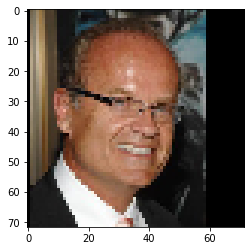

In [ ]:
plt.imshow(x_train[0].astype("float32"))
print(y_train[0])

## Use data augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size)
    ],
    name="data_augmentation",
)

x_train, y = training_generator[0]
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


## Implement multilayer perceptron (MLP)

In [ ]:

def mlp(x, hidden_units, dropout_rate, idx='1'):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate, name="mlp_dropout_" + idx + "_" + str(units))(x)
    return x


## Implement patch creation as a layer

In [ ]:

class Patches(layers.Layer):
    def __init__(self, patch_size, stride_size, name='patches', projection_dim=projection_dim, trainable=False, dtype='float32'):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        self.stride_size = stride_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.stride_size, self.stride_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({
            "patch_size": self.patch_size,
            "stride_size": self.stride_size
        })
        base_config = super(Patches, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


Let's display patches for a sample image

Image size: 72 X 72
Patch size: 36 X 36
Patches per image: 16
Elements per patch: 3888


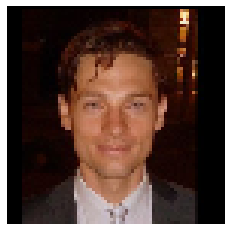

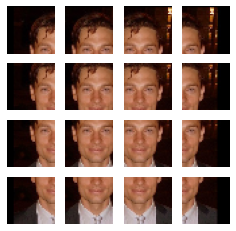

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("float32"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size, stride_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("float32"))
    plt.axis("off")

In [ ]:
patches.shape

TensorShape([1, 16, 3888])

## Implement the patch encoding layer

The `PatchEncoder` layer will linearly transform a patch by projecting it into a
vector of size `projection_dim`. In addition, it adds a learnable position
embedding to the projected vector.

In [ ]:

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim=projection_dim, name='patch_encoder', trainable=False, dtype='float32'):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        embedding = self.position_embedding(positions)
        embedding = tf.reshape(embedding, (1, -1, projection_dim))
        return self.projection(patch) + embedding

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_patches": self.num_patches,
        })
        base_config = super(PatchEncoder, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

_encoded_patches1 = PatchEncoder(num_patches, projection_dim, "patch_encoder")(patches)
_encoded_patches1[0].shape

TensorShape([16, 128])

## Build the ViT model

The ViT model consists of multiple Transformer blocks,
which use the `layers.MultiHeadAttention` layer as a self-attention mechanism
applied to the sequence of patches. The Transformer blocks produce a
`[batch_size, num_patches, projection_dim]` tensor, which is processed via an
classifier head with softmax to produce the final class probabilities output.

Unlike the technique described in the [paper](https://arxiv.org/abs/2010.11929),
which prepends a learnable embedding to the sequence of encoded patches to serve
as the image representation, all the outputs of the final Transformer block are
reshaped with `layers.Flatten()` and used as the image
representation input to the classifier head.
Note that the `layers.GlobalAveragePooling1D` layer
could also be used instead to aggregate the outputs of the Transformer block,
especially when the number of patches and the projection dimensions are large.

In [ ]:
import os

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Lambda, Dot, Activation, Concatenate, Layer

# KERAS_ATTENTION_DEBUG: If set to 1. Will switch to debug mode.
# In debug mode, the class Attention is no longer a Keras layer.
# What it means in practice is that we can have access to the internal values
# of each tensor. If we don't use debug, Keras treats the object
# as a layer and we can only get the final output.
debug_flag = int(os.environ.get('KERAS_ATTENTION_DEBUG', 0))


class Attention(object if debug_flag else Layer):

    def __init__(self, units=128, **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.units = units

    # noinspection PyAttributeOutsideInit
    def build(self, input_shape):
        input_dim = int(input_shape[-1])
        with K.name_scope(self.name if not debug_flag else 'attention'):
            self.attention_score_vec = Dense(input_dim, use_bias=False, name='attention_score_vec')
            self.h_t = Lambda(lambda x: x[:, -1, :], output_shape=(input_dim,), name='last_hidden_state')
            self.attention_score = Dot(axes=[1, 2], name='attention_score')
            self.attention_weight = Activation('softmax', name='attention_weight')
            self.context_vector = Dot(axes=[1, 1], name='context_vector')
            self.attention_output = Concatenate(name='attention_output')
            self.attention_vector = Dense(self.units, use_bias=False, activation='tanh', name='attention_vector')
        if not debug_flag:
            # debug: the call to build() is done in call().
            super(Attention, self).build(input_shape)

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.units

    def __call__(self, inputs, training=None, **kwargs):
        if debug_flag:
            return self.call(inputs, training, **kwargs)
        else:
            return super(Attention, self).__call__(inputs, training, **kwargs)

    # noinspection PyUnusedLocal
    def call(self, inputs, training=None, **kwargs):
        """
        Many-to-one attention mechanism for Keras.
        @param inputs: 3D tensor with shape (batch_size, time_steps, input_dim).
        @param training: not used in this layer.
        @return: 2D tensor with shape (batch_size, units)
        @author: felixhao28, philipperemy.
        """
        if debug_flag:
            self.build(inputs.shape)
        # Inside dense layer
        #              hidden_states            dot               W            =>           score_first_part
        # (batch_size, time_steps, hidden_size) dot (hidden_size, hidden_size) => (batch_size, time_steps, hidden_size)
        # W is the trainable weight matrix of attention Luong's multiplicative style score
        score_first_part = self.attention_score_vec(inputs)
        #            score_first_part           dot        last_hidden_state     => attention_weights
        # (batch_size, time_steps, hidden_size) dot   (batch_size, hidden_size)  => (batch_size, time_steps)
        h_t = self.h_t(inputs)
        score = self.attention_score([h_t, score_first_part])
        attention_weights = self.attention_weight(score)
        # (batch_size, time_steps, hidden_size) dot (batch_size, time_steps) => (batch_size, hidden_size)
        context_vector = self.context_vector([inputs, attention_weights])
        pre_activation = self.attention_output([context_vector, h_t])
        attention_vector = self.attention_vector(pre_activation)
        return attention_vector

    def get_config(self):
        """
        Returns the config of a the layer. This is used for saving and loading from a model
        :return: python dictionary with specs to rebuild layer
        """
        config = super(Attention, self).get_config()
        config.update({'units': self.units})
        return config

def FeedForward(inputs, dim, hidden_dim, dropout):
    net = Sequential([
        layers.Dense(hidden_dim, activation=tf.nn.gelu),
        layers.Dropout(dropout),
        layers.Dense(dim),
        layers.Dropout(dropout)
    ])

    return net(inputs)

def Transformer(encoded_patches):
    x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    x = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=projection_dim, dropout=0.1
    )(x1, x1)
    x = layers.LayerNormalization(epsilon=1e-6)(x + encoded_patches)
    f = FeedForward(x, projection_dim, projection_dim, 0.2)
    f = layers.LayerNormalization(epsilon=1e-6)(f + encoded_patches)

    return f

def transformer_encoder(inputs1, head_size=projection_dim, num_heads=8, ff_dim=projection_dim, dropout=0):
    # Normalization and Attention
    x1 = layers.LayerNormalization(epsilon=1e-6)(inputs1)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x1, x1)
    x = layers.Dropout(dropout)(x)
    res = x + inputs1
    
    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Dropout(dropout)(x)
    return x

# function for creating a vgg block
def vgg_block(layer_in, n_filters, n_conv):
	# add convolutional layers
	for _ in range(n_conv):
		layer_in = Conv2D(n_filters, (3,3), padding='same', activation='relu')(layer_in)
	# add max pooling layer
	layer_in = MaxPooling2D((2,2), strides=(2,2))(layer_in)
	return layer_in

# function for creating an identity or projection residual module
def residual_module(layer_in, n_filters):
    merge_input = layer_in
    # check if the number of filters needs to be increase, assumes channels last format
    if layer_in.shape[-1] != n_filters:
      merge_input = layers.Conv2D(n_filters, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
    # conv1
    conv1 = layers.Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
    # conv2
    conv2 = layers.Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(conv1)
    # add filters, assumes filters/channels last
    layer_out = layers.Add()([conv2, merge_input])
    # activation function
    layer_out = Activation('relu')(layer_out)
    return layer_out

In [ ]:
from __future__ import print_function
from keras.models import load_model
from keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import scipy
import datetime
from keras.layers import Input, Conv2D, UpSampling2D, MaxPooling2D, Dense, Conv2DTranspose, Flatten, GlobalAveragePooling2D, Reshape, Activation
from keras.models import Model, Sequential
from keras import optimizers
import keras.utils
from keras.callbacks import EarlyStopping, ModelCheckpoint
from PIL import Image
from glob import glob
import cv2

num_embedding = 141

In [ ]:
def mahalanobis_distance(patches):
  e = (patches - tf.math.reduce_mean(patches, axis=0)) / tf.math.reduce_std(patches)
  b_vector = tf.matmul(tf.linalg.inv(tf.convert_to_tensor(P, dtype=tf.float32)), tf.transpose(e))
  b_mean = tf.expand_dims(tf.math.reduce_mean(b_vector, axis=1), axis=1)
  inv = tfp.stats.covariance(b_vector)
  return tf.matmul(tf.transpose(tf.matmul((b_vector - b_mean), tf.matmul(tf.transpose(inv), inv)/tf.norm(inv, ord=2))), (b_vector - b_mean))

latent_space_size = num_embedding

initializer = keras.initializers.RandomNormal(mean=0., stddev=0.15)

def create_classifier(inputs, labels):
    
    # classification problem
    # output = inputs
    # for i in range(4):
    #   output = residual_module(output, 32)
    
    encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(72, 72, 3)),
            tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
            # generative problem
            tf.keras.layers.MaxPooling2D(pool_size=(2,2), padding='same'),
            tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
            # generative problem
            tf.keras.layers.MaxPooling2D(pool_size=(2,2), padding='same'),
            tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
        ]
    )

    output = encoder(inputs)
    flatten = layers.Flatten()(output)
    output = layers.BatchNormalization()(flatten)

    mean, sigma = Dense(latent_space_size, activation='relu')(flatten), Dense(latent_space_size, activation='relu', kernel_initializer=initializer)(flatten)

    mean = layers.Concatenate(axis=-1)([mean, labels])
    sigma = layers.Concatenate(axis=-1)([sigma, labels])

    embed = layers.Embedding(latent_space_size+num_classes, latent_space_size)(mean + keras.activations.exponential(-0.5*sigma))

    encoder_output_z = layers.Concatenate(axis=-2)([tf.expand_dims(mean, 2), tf.matmul(tf.transpose(embed, (0, 2, 1)), tf.expand_dims(sigma, 2))])

    encoder_output_z = layers.BatchNormalization()(encoder_output_z)

    h = layers.BatchNormalization()(encoder_output_z[:,:,0])
    # generative problem
    h = layers.Concatenate(axis=-1)([h, labels])
    h = layers.BatchNormalization()(h)
    # generative problem
    h = layers.Dense(18*18, activation='relu')(h)
    # classification problem
    h = layers.Dense(18*18, activation='relu')(h)

    # generative problem
    decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(18*18,)),
            tf.keras.layers.Dense(units=18*18, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(18, 18, 1)),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, padding='same',
                activation='relu'),
            UpSampling2D((2,2)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, padding='same',
                activation='relu'),
            UpSampling2D((2,2)),
            # No activation
            tf.keras.layers.Conv2D(
                filters=3, kernel_size=3, padding='same', activation='relu'),
        ]
    )
    # Create patches.

    decoder_output = decoder(h)
    # Create the Keras model.
    return decoder_output


## Compile, train, and evaluate the mode

In [ ]:
from keras import callbacks
import tensorflow_probability as tfp

input_shape=(72,72,3)
label_shape=(num_classes,)

inputs = tf.keras.Input(shape=input_shape)
labels = tf.keras.Input(shape=label_shape)

classifier = keras.Model(inputs=[inputs, labels], outputs=create_classifier(inputs, labels))
classifier.summary()

dot_img_file = '/content/model_1.png'
tf.keras.utils.plot_model(classifier, to_file=dot_img_file, show_shapes=True)

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_45 (InputLayer)          [(None, 72, 72, 3)]  0           []                               
                                                                                                  
 sequential_18 (Sequential)     (None, 18, 18, 128)  93248       ['input_45[0][0]']               
                                                                                                  
 flatten_13 (Flatten)           (None, 41472)        0           ['sequential_18[0][0]']          
                                                                                                  
 input_46 (InputLayer)          [(None, 435)]        0           []                               
                                                                                            

AttributeError: ignored

In [ ]:
import time
from tqdm import tqdm

def custom_loss_func_logits(y_true, logits):
  result = tf.keras.losses.CosineSimilarity(axis=1)(y_true, logits)
  mse = tfr.keras.losses.MeanSquaredLoss()(y_true, logits)
  # e = (logits - tf.math.reduce_mean(logits, axis=0)) / tf.math.reduce_std(logits)
  # b_vector = tf.matmul(tf.linalg.inv(tf.convert_to_tensor(P, dtype=tf.float32)), e)
  # b_mean = tf.expand_dims(tf.math.reduce_mean(b_vector, axis=1), axis=1)
  # inv = result
  # distance = tf.math.reduce_sum(tf.matmul(tf.transpose(b_vector - b_mean), (b_vector - b_mean)))
  # distance = tf.norm(y_true - logits, ord=2)
  return tf.abs(result) + mse

def custom_loss_func_patches(y_true, logits):
    e = (logits - tf.math.reduce_mean(logits, axis=0)) / tf.math.reduce_std(logits)
    e = tf.reshape(tf.math.reduce_mean(e, axis=0), (16,601))
    b_vector = tf.matmul(tf.linalg.inv(tf.convert_to_tensor(P, dtype=tf.float32)), tf.transpose(e))
    b_mean = tf.expand_dims(tf.math.reduce_mean(b_vector, axis=1), axis=1)
    inv = tfp.stats.covariance(b_vector)
    return tf.math.reduce_sum(tf.matmul(tf.transpose(tf.matmul((b_vector - b_mean), tf.matmul(tf.transpose(inv), inv))), (b_vector - b_mean)))

def custom_loss_func_mlp(y_true, logits):
    return tf.math.reduce_sum(tf.matmul(tf.transpose(logits), logits))
    
def custom_metric_func_logits(y_true, logits):
    return keras.metrics.CategoricalAccuracy(name="accuracy")(y_true, logits)

def custom_metric_func_mlp(y_true, logits):
    return tf.matmul(tf.transpose(logits), logits)

def custom_metric_func_patches(y_true, logits):
    e = (logits - tf.math.reduce_mean(logits, axis=0)) / tf.math.reduce_std(logits)
    e = tf.reshape(tf.math.reduce_mean(e, axis=0), (16,601))
    b_vector = tf.matmul(tf.linalg.inv(tf.convert_to_tensor(P, dtype=tf.float32)), tf.transpose(e))
    b_mean = tf.expand_dims(tf.math.reduce_mean(b_vector, axis=1), axis=1)
    return tf.matmul(tf.transpose(tf.matmul((b_vector - b_mean), tfp.stats.covariance(b_vector))), (b_vector - b_mean))

def run_experiment(model):

    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    early_stop = EarlyStopping(monitor='loss', min_delta=0.001, patience=3, mode='min', verbose=1)
    
    model.compile(loss=[keras.losses.mean_squared_error],
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6, clipnorm=1.0), 
            metrics=[keras.metrics.mean_squared_error])

    checkpoint_filepath = "/content/vit_face_recognition_model.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="loss",
        save_best_only=True,
        save_weights_only=False,
        mode='min'
    )

    history = model.fit(training_generator,
        epochs=num_epochs,
        verbose=1,
        batch_size=batch_size,
        validation_data=validation_generator, 
        callbacks=[checkpoint_callback, early_stop, tensorboard_callback])

    return history

history = run_experiment(classifier)

Epoch 1/100
50/50 [==============================] - 24s 436ms/step - loss: 0.0718 - mean_squared_error: 0.0718 - val_loss: 0.7371 - val_mean_squared_error: 0.7371
Epoch 2/100
50/50 [==============================] - 21s 421ms/step - loss: 0.0416 - mean_squared_error: 0.0416 - val_loss: 0.1158 - val_mean_squared_error: 0.1158
Epoch 3/100
50/50 [==============================] - 21s 422ms/step - loss: 0.0361 - mean_squared_error: 0.0361 - val_loss: 0.0385 - val_mean_squared_error: 0.0385
Epoch 4/100
50/50 [==============================] - 22s 432ms/step - loss: 0.0327 - mean_squared_error: 0.0327 - val_loss: 0.0352 - val_mean_squared_error: 0.0352
Epoch 5/100
50/50 [==============================] - 21s 428ms/step - loss: 0.0307 - mean_squared_error: 0.0307 - val_loss: 0.0325 - val_mean_squared_error: 0.0325
Epoch 6/100
50/50 [==============================] - 21s 421ms/step - loss: 0.0293 - mean_squared_error: 0.0293 - val_loss: 0.0344 - val_mean_squared_error: 0.0344
Epoch 7/100
50/5

In [ ]:
new_model = Model(inputs=classifier.inputs, outputs=classifier.layers[-8].output)
new_model([x_valid[:32], y_valid_new[:32]]).shape

TensorShape([32, 141])

In [ ]:
!cp -Rf /content/vit_face_recognition_model.h5 /content/drive/MyDrive/CI7000/CI7000_Project_Dissertation/datasets/

In [ ]:
import imageio

dirname = os.path.join(DATADIR, 'CACD2000', 'CACD2000')

img1 = imageio.imread(os.path.join(DATADIR, 'CACD2000', 'CACD2000', os.listdir(dirname)[1]))

In [ ]:
(x_valid, y_valid), out_valid = validation_generator[30]

In [ ]:
y_valid[0].shape

(435,)

In [ ]:
np.argmax(y_valid, axis=1)

array([92, 92, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93,
       93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 94, 94, 94, 94, 94, 94, 94,
       94, 94, 94, 94, 94, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95,
       95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 96, 96])

In [ ]:
from sklearn.svm import SVC

svm = SVC(C=0.2)

In [ ]:
emb

<tf.Tensor: shape=(64, 141), dtype=float32, numpy=
array([[1.0942    , 1.9315778 , 0.8217392 , ..., 0.9619243 , 1.5235627 ,
        3.2596083 ],
       [3.2611845 , 1.841311  , 0.6565478 , ..., 0.76358026, 4.2213526 ,
        5.5435705 ],
       [3.069718  , 2.1601562 , 0.7655815 , ..., 0.8461385 , 2.7094412 ,
        1.7033329 ],
       ...,
       [2.3766627 , 2.335898  , 1.0158954 , ..., 0.8498222 , 3.5694559 ,
        3.2899697 ],
       [2.4407635 , 1.7890562 , 1.0650542 , ..., 0.89633125, 1.4515274 ,
        2.4066668 ],
       [3.3718407 , 1.9340822 , 0.91316926, ..., 0.81893533, 3.2833378 ,
        4.087172  ]], dtype=float32)>

In [ ]:
mat = scipy.io.loadmat(os.path.join(DATADIR, 'AgeDB_metadata.mat'))
fileno = list(map(lambda x: x[0], mat['fileno'][0]))
filename = list(map(lambda x: x[0], mat['filename'][0]))
name = list(map(lambda x: x[0], mat['name'][0]))
age = list(map(lambda x: x[0], mat['age'][0]))
gender = list(map(lambda x: x[0], mat['gender'][0]))
metadata_agedb = pd.DataFrame(np.stack([fileno, filename, name, age, gender]).T, 
                              columns=['fileno', 'filename', 'name', 'age', 'gender'])
metadata_agedb['age'] = metadata_agedb['age'].astype(np.int)
metadata_agedb['fileno'] = metadata_agedb['fileno'].astype(np.int)
metadata_agedb['name'] = metadata_agedb['name'].astype(np.str)
metadata_agedb['filename'] = metadata_agedb['filename'].astype(np.str)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addi

In [ ]:
metadata_agedb

,fileno,filename,name,age,gender
7997,2359,2359_AbeVigoda_20_m.jpg,AbeVigoda,20,m
7960,2325,2325_AbeVigoda_49_m.jpg,AbeVigoda,49,m
7961,2326,2326_AbeVigoda_51_m.jpg,AbeVigoda,51,m
7962,2327,2327_AbeVigoda_52_m.jpg,AbeVigoda,52,m
7963,2328,2328_AbeVigoda_53_m.jpg,AbeVigoda,53,m
...,...,...,...,...,...
10226,4365,4365_RalphMacchio_50_m.jpg,RalphMacchio,50,m
10227,4366,4366_RalphMacchio_51_m.jpg,RalphMacchio,51,m
10228,4367,4367_RalphMacchio_52_m.jpg,RalphMacchio,52,m
10229,4368,4368_RalphMacchio_53_m.jpg,RalphMacchio,53,m


In [ ]:
metadata_agedb = metadata_agedb.sort_values(by=['name', 'age'])
names = np.unique(metadata_agedb['name'])[:435]
idx = [metadata_agedb['name'] == name for name in names]
result_idx = [False]*len(metadata_agedb)
for i in idx:
  result_idx = np.logical_or(result_idx, i)
image_size = 72
batch_size = 128
metadata_agedb = metadata_agedb.loc[result_idx]

testing_iterator = augmentation_generator.flow_from_dataframe(metadata_agedb, directory=os.path.join(DATADIR, "AgeDB", "AgeDB"), x_col='filename', y_col='name', class_mode='categorical', 
                                        target_size=(image_size,image_size), color_mode='rgb', batch_size=batch_size, shuffle=False)
testing_gen = augmentation_generator.flow_from_dataframe(metadata_agedb, directory=os.path.join(DATADIR, "AgeDB", "AgeDB"), x_col='filename', y_col=['name', 'name'], class_mode='raw', 
                                        target_size=(image_size,image_size), color_mode='rgb', batch_size=batch_size, shuffle=False)

Found 12723 validated image filenames belonging to 435 classes.
Found 12723 validated image filenames.


In [ ]:
testing_generator = DataGenerator(testing_iterator)

In [ ]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform
from tensorflow.keras.models import Model, load_model
from sklearn.svm import SVC

classifier = load_model("/content/vit_face_recognition_model.h5")

param_grid = {
    "C": loguniform.rvs(0.1, 100, size=5),
    "gamma": loguniform.rvs(1e-4, 1e-1, size=5),
}
# 6th layer gives 92.66 % accuracy
new_model = Model(inputs=classifier.inputs, outputs=classifier.layers[-6].output)
acc = []
class_counter = 434
for i in tqdm(range(50)):
  (x_valid, y_valid), out_valid = testing_generator[i]
  (x_valid, y_valid_new) = testing_gen[i]

  # y_valid = np.zeros(y_valid.shape)
  # classes = y_valid_new[:, 1]
  # unq_classes = np.unique(classes)
  # for c in unq_classes:
  #   y_valid[classes==c, class_counter] = 1
  #   class_counter -= 1

  emb = new_model([x_valid, np.random.randint(0, 1, (128, 435))])

  emb_train = []
  new_train_classes = []
  emb_test = []
  new_test_classes = []
  for c in unq_classes:

    emb_train.append(emb[classes == c][:int(0.7*len(emb[classes == c]))])
    emb_test.append(emb[classes == c][int(0.7*len(emb[classes == c])):])
    new_train_classes += classes[classes==c][:int(0.7*len(classes[classes==c]))].tolist()
    new_test_classes += classes[classes==c][int(0.7*len(classes[classes==c])):].tolist()

  emb_train = np.vstack(emb_train)
  emb_test = np.vstack(emb_test)

  svm = RandomizedSearchCV(SVC(), param_grid, cv=2)
  svm.fit(emb_train.reshape(-1,717), new_train_classes)
  acc.append(accuracy_score(new_test_classes, svm.predict(emb_test.reshape(-1,717))))



  2%|▏         | 1/50 [01:04<52:16, 64.00s/it]


KeyboardInterrupt: ignored

In [ ]:
# -5 layer with embedding
np.mean(acc), np.std(acc)

NameError: ignored

In [ ]:
# - 6 layer with embedding
np.mean(acc), np.std(acc)

(0.9455292987405863, 0.08117312311915173)

In [ ]:
# - 7 layer with embedding
np.mean(acc), np.std(acc)

(0.505574964141306, 0.13819464730487294)

In [ ]:
# - 8 layer
np.mean(acc), np.std(acc)

(0.3974248103221117, 0.11541513082673553)

In [ ]:
# - 9 layer
np.mean(acc), np.std(acc)

(0.3764524637032133, 0.08313193516805992)

In [ ]:
# - 10 layer
np.mean(acc), np.std(acc)

(0.4454123587556871, 0.12339650200003975)

In [ ]:
with mlflow.start_run() as run:
    mlflow.keras.log_model(vit_classifier, "models")

INFO:tensorflow:Assets written to: /tmp/tmps_9jhcck/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmps_9jhcck/model/data/model/assets
2022/05/29 01:22:55 WARNING mlflow.utils.requirements_utils: Found tensorflow version (2.8.0+zzzcolab20220506162203) contains a local version label (+zzzcolab20220506162203). MLflow logged a pip requirement for this package as 'tensorflow==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/29 01:23:21 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmps_9jhcck/model, flavor: keras), fall back to return ['tensorflow==2.8.0', 'keras==2.8.0']. Set logging level to DEBUG to see the full traceback.


In [ ]:
def custom_loss_func_logits(y_true, logits):
  result = tf.keras.losses.CosineSimilarity(axis=1)(y_true, logits)
  mse = tfr.keras.losses.MeanSquaredLoss()(y_true, logits)
  # e = (logits - tf.math.reduce_mean(logits, axis=0)) / tf.math.reduce_std(logits)
  # b_vector = tf.matmul(tf.linalg.inv(tf.convert_to_tensor(P, dtype=tf.float32)), e)
  # b_mean = tf.expand_dims(tf.math.reduce_mean(b_vector, axis=1), axis=1)
  # inv = result
  # distance = tf.math.reduce_sum(tf.matmul(tf.transpose(b_vector - b_mean), (b_vector - b_mean)))
  # distance = tf.norm(y_true - logits, ord=2)
  return tf.abs(result) + mse

In [ ]:
!cp -Rf mlruns /content/drive/MyDrive/CI7000/CI7000_Project_Dissertation/datasets/models/mlflow2/

In [ ]:
!cp -Rf logs /content/drive/MyDrive/CI7000/CI7000_Project_Dissertation/datasets/models/

In [ ]:
!cp /content/drive/MyDrive/CI7000/CI7000_Project_Dissertation/datasets/Keras_FACE/vit_face_recognition_model.h5 /content/

In [ ]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform
from tensorflow.keras.models import Model, load_model
from sklearn.svm import SVC

classifier = load_model("/content/vit_face_recognition_model.h5")

# 6th layer gives 92.66 % accuracy
new_model = Model(inputs=classifier.inputs, outputs=classifier.layers[-6].output)

In [ ]:
i = 50

(x_valid, y_valid), out_valid = testing_generator[i]
(x_valid, y_valid_new) = testing_gen[i]

class_counter = 0
y_valid = np.zeros(y_valid.shape)
classes = y_valid_new[:, 1]
unq_classes = np.unique(classes)
for c in unq_classes:
  y_valid[classes==c, class_counter] = 1
  class_counter += 1

emb = new_model([x_valid, y_valid])

In [ ]:
out_model = Model(inputs=classifier.inputs, outputs=classifier.layers[-2].output)

In [ ]:
img1 = x_valid * 255
img2 = classifier([x_valid, y_valid]) * 255

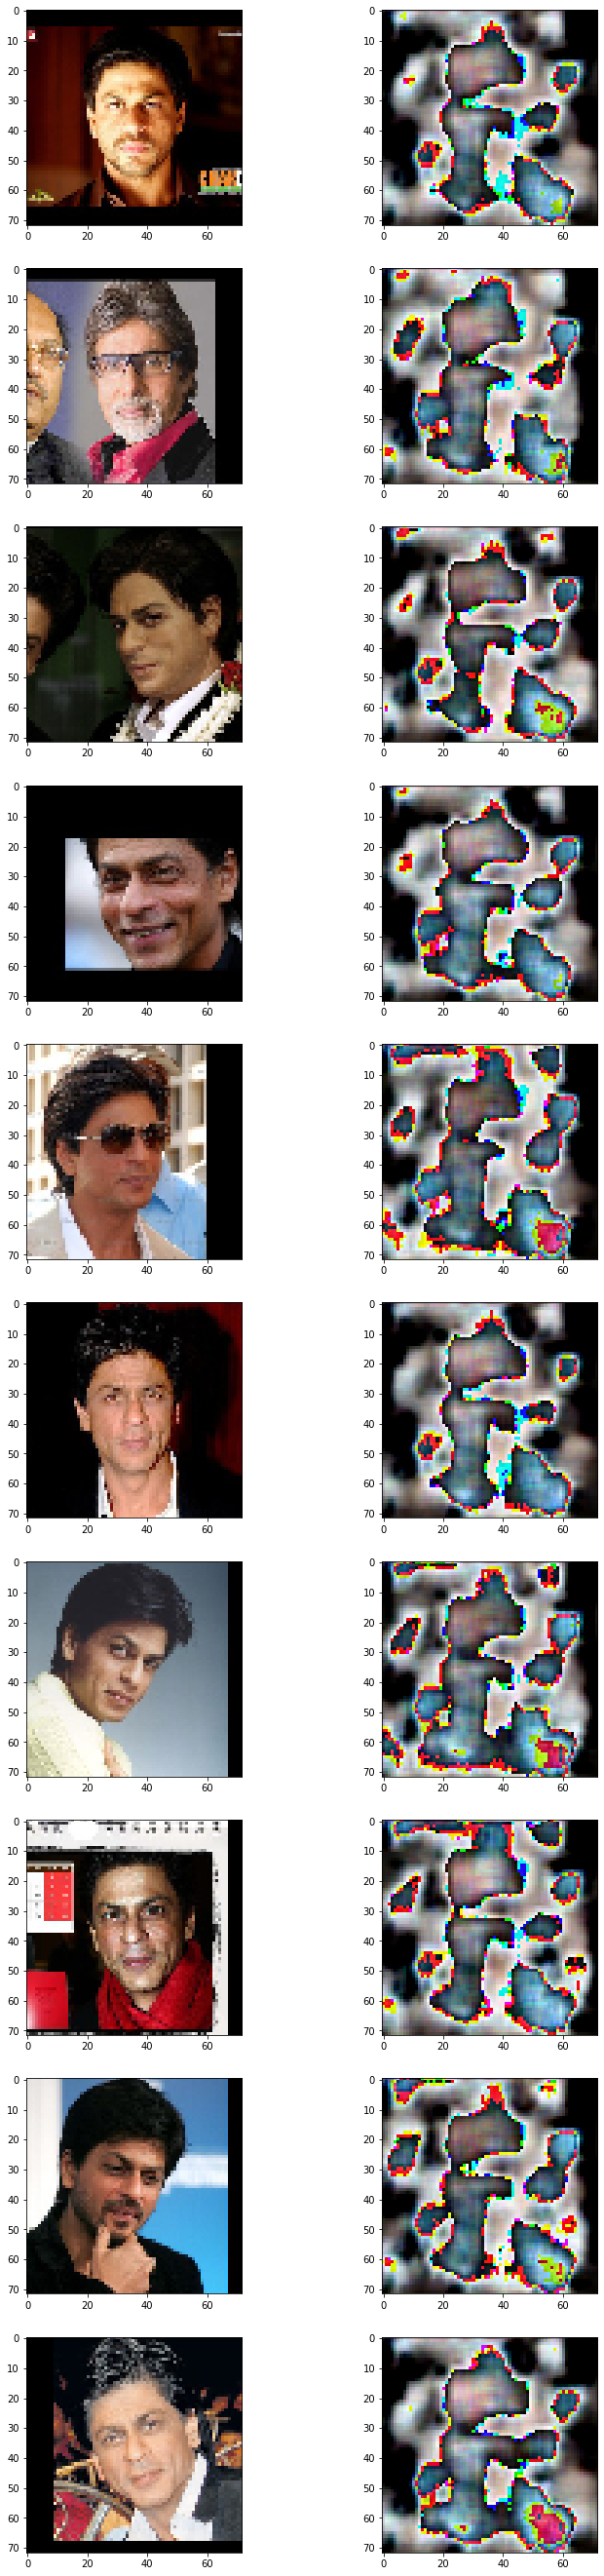

In [ ]:
fig = plt.figure(figsize=(12,48))
for i in range(10):
  image1 = (img1).astype(np.uint8)[i]
  image2 = img2.numpy().astype(np.uint8)[i]

  plt.subplot(10, 2, 2*i+1)
  plt.imshow(image1)
  plt.subplot(10, 2, 2*i+2)
  plt.imshow(image2)

In [ ]:
def euclidean_distance(y_first, y_second):
  distance = tf.norm(y_first - y_second, ord=2)
  return distance.numpy()

def exponential_cosine_similarity(y_first, y_second):
  e = tf.keras.metrics.CosineSimilarity()(y_first, y_second)

def kl_divergence(y_first, y_second):
  e = tf.keras.metrics.kl_divergence(y_first, y_second)

  return e.numpy()

def load_image(image_path):
  image = cv2.imread(image_path, cv2.IMREAD_COLOR)
  image = cv2.resize(image, (72,72))
  return tf.convert_to_tensor(l2_normalize(prewhiten(image)).reshape(-1,72,72,3))

face_inference = pd.DataFrame(columns=['image_file1', 'image_file2', 'type', 'euclidean_distance', 'exponential_cosine_similarity'])
face_inference_array = []

# similar images in comparison
names = np.unique(metadata_agedb['name'])
for ii, name in enumerate(names):
  similar_images = metadata_agedb.loc[metadata_agedb['name'] == name, 'filename']
  image_file1 = similar_images.iloc[0]
  image_file2 = similar_images.iloc[1]

  y_first = new_model(load_image(os.path.join(DATADIR, "AgeDB", "AgeDB", image_file1)))
  y_second = new_model(load_image(os.path.join(DATADIR, "AgeDB", "AgeDB", image_file2)))

  face_inference_array.append([
    image_file1, image_file2, 'similar', euclidean_distance(y_first, y_second), exponential_cosine_similarity(y_first, y_second), kl_divergence(y_first, y_second)
  ])

# dissimilar images in comparison
for ii, name in enumerate(names[:-1]):
  dissimilar_images1 = metadata_agedb.loc[metadata_agedb['name'] == name, 'filename']
  dissimilar_images2 = metadata_agedb.loc[metadata_agedb['name'] == names[ii+1], 'filename']
  image_file1 = dissimilar_images1.iloc[0]
  image_file2 = dissimilar_images2.iloc[0]

  y_first = new_model(load_image(os.path.join(DATADIR, "AgeDB", "AgeDB", image_file1)))
  y_second = new_model(load_image(os.path.join(DATADIR, "AgeDB", "AgeDB", image_file2)))

  face_inference_array.append([
    image_file1, image_file2, 'dissimilar', euclidean_distance(y_first, y_second), exponential_cosine_similarity(y_first, y_second), kl_divergence(y_first, y_second)
  ])

In [ ]:
face_inference = pd.DataFrame(face_inference_array, columns=['image_file1', 'image_file2', 'type', 'euclidean_distance', 'exponential_cosine_similarity', 'kl_divergence'])
face_inference

,image_file1,image_file2,type,euclidean_distance,exponential_cosine_similarity,kl_divergence
0,2359_AbeVigoda_20_m.jpg,2325_AbeVigoda_49_m.jpg,similar,22.200977,None,[1055.3198]
1,778_AdolfHitlerr_11_m.jpg,779_AdolfHitlerr_30_m.jpg,similar,27.380468,None,[1020.1406]
2,1592_AlCorley_20_m.jpg,1593_AlCorley_22_m.jpg,similar,4.715067,None,[13.137367]
3,507_AlKapone_5_m.jpg,509_AlKapone_23_m.jpg,similar,7.272701,None,[74.24714]
4,1638_AlPacino_18_m.jpg,1618_AlPacino_20_m.jpg,similar,3.764957,None,[13.903228]
...,...,...,...,...,...,...
474,844_mahatmagandhi_7_m.jpg,425_merrillcharles_17_m.jpg,dissimilar,28.894318,None,[1046.0006]
475,425_merrillcharles_17_m.jpg,255_michaeljackson_3_m.jpg,dissimilar,27.567446,None,[873.4857]
476,255_michaeljackson_3_m.jpg,628_mitsotakis_34_m.jpg,dissimilar,7.481115,None,[0.31716406]
477,628_mitsotakis_34_m.jpg,491_motherTereza_11_f.jpg,dissimilar,29.442993,None,[1005.0889]


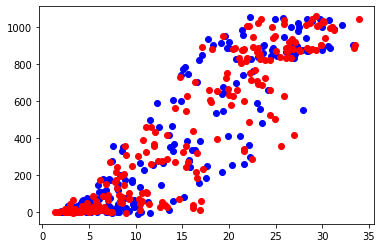

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(face_inference.loc[face_inference['type'] == 'similar', 'euclidean_distance'], face_inference.loc[face_inference['type'] == 'similar', 'kl_divergence'].apply(lambda x: x[0]), c='blue')
plt.scatter(face_inference.loc[face_inference['type'] == 'dissimilar', 'euclidean_distance'], face_inference.loc[face_inference['type'] == 'dissimilar', 'kl_divergence'].apply(lambda x: x[0]), c='red')
plt.show()

In [ ]:
def euclidean_distance(y_first, y_second):
  distance = tf.norm(y_first - y_second, ord=2)
  return distance.numpy()

def exponential_cosine_similarity(y_first, y_second):
  e = tf.keras.metrics.CosineSimilarity()(y_first, y_second)

  return e.numpy()

def load_image(image_path):
  image = cv2.imread(image_path, cv2.IMREAD_COLOR)
  image = cv2.resize(image, (160,160))
  return tf.convert_to_tensor(l2_normalize(prewhiten(image)).reshape(-1,160,160,3))

facenet_inference = pd.DataFrame(columns=['image_file1', 'image_file2', 'type', 'euclidean_distance', 'exponential_cosine_similarity'])
facenet_inference_array = []

# similar images in comparison
names = np.unique(metadata_agedb['name'])
for ii, name in enumerate(names):
  similar_images = metadata_agedb.loc[metadata_agedb['name'] == name, 'filename']
  image_file1 = similar_images.iloc[0]
  image_file2 = similar_images.iloc[1]

  y_first = facenet_model(load_image(os.path.join(DATADIR, "AgeDB", "AgeDB", image_file1)))
  y_second = facenet_model(load_image(os.path.join(DATADIR, "AgeDB", "AgeDB", image_file2)))

  embedding_first = pca_embedding.transform(y_first)
  embedding_second = pca_embedding.transform(y_second)

  facenet_inference_array.append([
    image_file1, image_file2, 'similar', euclidean_distance(y_first, y_second), exponential_cosine_similarity(y_first, y_second), embedding_first[:, 0], embedding_first[:, 1], embedding_first[:, 2], 
    embedding_second[:, 0], embedding_second[:, 1], embedding_second[:, 2]
  ])

# dissimilar images in comparison
for ii, name in enumerate(names[:-1]):
  dissimilar_images1 = metadata_agedb.loc[metadata_agedb['name'] == name, 'filename']
  dissimilar_images2 = metadata_agedb.loc[metadata_agedb['name'] == names[ii+1], 'filename']
  image_file1 = dissimilar_images1.iloc[0]
  image_file2 = dissimilar_images2.iloc[0]

  y_first = facenet_model(load_image(os.path.join(DATADIR, "AgeDB", "AgeDB", image_file1)))
  y_second = facenet_model(load_image(os.path.join(DATADIR, "AgeDB", "AgeDB", image_file2)))

  embedding_first = pca_embedding.transform(y_first)
  embedding_second = pca_embedding.transform(y_second)

  facenet_inference_array.append([
    image_file1, image_file2, 'dissimilar', euclidean_distance(y_first, y_second), exponential_cosine_similarity(y_first, y_second), embedding_first[:, 0], embedding_first[:, 1], embedding_first[:, 2], 
    embedding_second[:, 0], embedding_second[:, 1], embedding_second[:, 2]
  ])

In [ ]:
facenet_inference = pd.DataFrame(facenet_inference_array, columns=['image_file1', 'image_file2', 'type', 'euclidean_distance', 'exponential_cosine_similarity', 
                                                                   'first_dimension_1', 'first_dimension_2', 'first_dimension_3', 'second_dimension_1', 'second_dimension_2', 'second_dimension_3'])
facenet_inference

,image_file1,image_file2,type,euclidean_distance,exponential_cosine_similarity,first_dimension_1,first_dimension_2,first_dimension_3,second_dimension_1,second_dimension_2,second_dimension_3
0,2359_AbeVigoda_20_m.jpg,2325_AbeVigoda_49_m.jpg,similar,12.631009,0.205139,[-0.17936954731480986],[-0.36200243411308697],[-4.15344695804428],[3.815130811948409],[2.4590872323038475],[-1.0239232749927403]
1,778_AdolfHitlerr_11_m.jpg,779_AdolfHitlerr_30_m.jpg,similar,7.408995,0.437441,[-3.276677517803022],[0.11307326326765807],[0.9949329999358635],[-0.9531163377115746],[-0.39157990546061855],[-0.12956150987680876]
2,1592_AlCorley_20_m.jpg,1593_AlCorley_22_m.jpg,similar,15.354284,0.119938,[2.767114329896576],[-0.5615283324406373],[4.524722078931511],[-5.0237761342808875],[-2.633244613797316],[-0.22806049673915396]
3,507_AlKapone_5_m.jpg,509_AlKapone_23_m.jpg,similar,12.681777,0.164384,[-1.0893313656350927],[-0.34664363152377714],[-0.43352329545110707],[-2.066308352427919],[-2.4650521053962446],[-1.5806055680319666]
4,1638_AlPacino_18_m.jpg,1618_AlPacino_20_m.jpg,similar,14.175030,0.064450,[-2.7571404861524322],[1.4983846827302398],[0.057606654488005005],[3.088756510561762],[-3.540293860739749],[-1.0674129209610097]
...,...,...,...,...,...,...,...,...,...,...,...
474,844_mahatmagandhi_7_m.jpg,425_merrillcharles_17_m.jpg,dissimilar,10.070749,0.276248,[-3.3225564992721153],[-2.452587678048918],[0.6241437084184133],[-1.3777250415622986],[-1.6099604906491303],[1.7087313058152316]
475,425_merrillcharles_17_m.jpg,255_michaeljackson_3_m.jpg,dissimilar,8.469596,0.055530,[-1.3777250415622986],[-1.6099604906491303],[1.7087313058152316],[-1.378516344391277],[-1.3085395938897377],[-0.024146260984834203]
476,255_michaeljackson_3_m.jpg,628_mitsotakis_34_m.jpg,dissimilar,6.239937,0.353518,[-1.378516344391277],[-1.3085395938897377],[-0.024146260984834203],[-2.1683755118319517],[0.2512794400050531],[0.5407004590964635]
477,628_mitsotakis_34_m.jpg,491_motherTereza_11_f.jpg,dissimilar,12.617073,0.031614,[-2.1683755118319517],[0.2512794400050531],[0.5407004590964635],[-1.4021700297097888],[0.8503593955883417],[3.404444169144628]


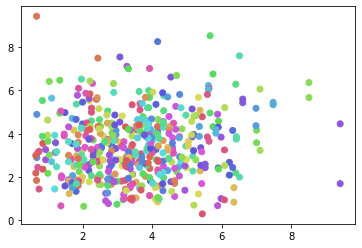

In [ ]:
import seaborn as sns

colors = np.array(sns.color_palette("hls", len(np.unique(facenet_inference['image_file1']))))
map_colors = dict(zip(np.unique(facenet_inference['image_file1']).tolist(), colors.tolist()))

facenet_inference['first_distance_from_origin'] = np.sqrt(facenet_inference['first_dimension_1'].apply(lambda x: x[0])**2 + facenet_inference['first_dimension_2'].apply(lambda x: x[0])**2 + facenet_inference['first_dimension_3'].apply(lambda x: x[0])**2)
facenet_inference['second_distance_from_origin'] = np.sqrt(facenet_inference['second_dimension_1'].apply(lambda x: x[0])**2 + facenet_inference['second_dimension_2'].apply(lambda x: x[0])**2 + facenet_inference['second_dimension_3'].apply(lambda x: x[0])**2)
plt.scatter(facenet_inference.loc[facenet_inference['type'] == 'dissimilar', 'first_distance_from_origin'], facenet_inference.loc[facenet_inference['type'] == 'dissimilar', 'second_distance_from_origin'], c=[map_colors[c] for c in facenet_inference.loc[facenet_inference['type'] == 'dissimilar', 'image_file1']])
plt.scatter(facenet_inference.loc[facenet_inference['type'] == 'similar', 'first_distance_from_origin'], facenet_inference.loc[facenet_inference['type'] == 'similar', 'second_distance_from_origin'], c=[map_colors[c] for c in facenet_inference.loc[facenet_inference['type'] == 'similar', 'image_file1']])
plt.show()

In [ ]:
embeddings = tf.concat(embeddings, axis=0).numpy()

In [ ]:
pca_embedding = PCA(n_components=3)
pca_embedding.fit(embeddings)
print(sum(pca_embedding.explained_variance_ratio_))

0.20038923248648643


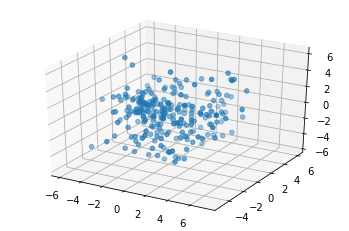

In [ ]:
embedding_transform = pca_embedding.transform(embeddings)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(embedding_transform[:, 0], embedding_transform[:, 1], embedding_transform[:, 2])
plt.show()

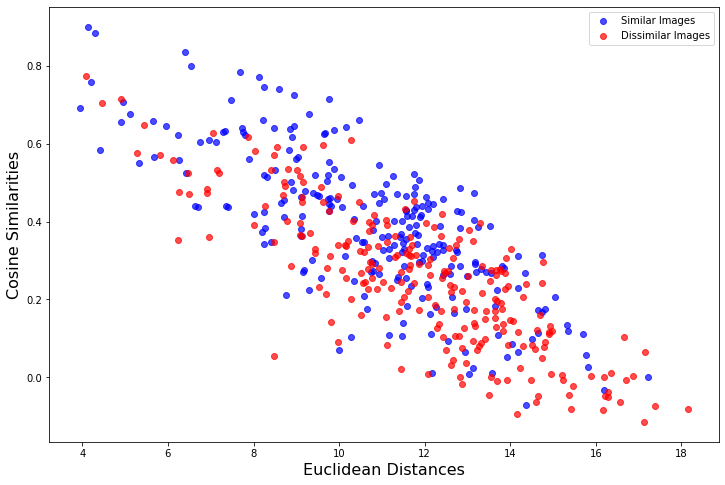

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,8))
plt.scatter(facenet_inference.loc[facenet_inference['type'] == 'similar', 'euclidean_distance'], facenet_inference.loc[facenet_inference['type'] == 'similar', 'exponential_cosine_similarity'], c='blue', label='Similar Images', alpha=0.7)
plt.scatter(facenet_inference.loc[facenet_inference['type'] == 'dissimilar', 'euclidean_distance'], facenet_inference.loc[facenet_inference['type'] == 'dissimilar', 'exponential_cosine_similarity'], c='red', label='Dissimilar Images', alpha=0.7)
plt.xlabel("Euclidean Distances", fontsize=16)
plt.ylabel("Cosine Similarities", fontsize=16)
plt.legend()
plt.show()

## FaceNet Embeddings performing Age comparison

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

def euclidean_distance(y_first, y_second):
  distance = tf.norm(y_first - y_second, ord=2)
  return distance.numpy()

def exponential_cosine_similarity(y_first, y_second):
  e = tf.keras.metrics.CosineSimilarity()(y_first, y_second)

  return e.numpy()

def load_image(image_path):
  image = cv2.imread(image_path, cv2.IMREAD_COLOR)
  image = cv2.resize(image, (160,160))
  return tf.convert_to_tensor(l2_normalize(prewhiten(image)).reshape(-1,160,160,3))

established_sample = metadata_agedb.loc[metadata_agedb['name'] == 'AdolfHitlerr']

stream_sample = metadata_agedb.loc[metadata_agedb['name'] != "AdolfHitlerr"]

new_dataframe = pd.concat([established_sample, stream_sample], axis=0)

embeddings_facenet = []

images = []
for i in tqdm(range(len(established_sample) + len(stream_sample))):
  images.append(load_image(os.path.join(DATADIR, "AgeDB", "AgeDB", new_dataframe['filename'].iloc[i])))
  if (i+1) % 320 == 0:
    embeddings_facenet.append(facenet_model(np.stack(images).reshape(-1,160,160,3)))
    images = []

embeddings_facenet.append(facenet_model(np.stack(images).reshape(-1,160,160,3)))

100%|██████████| 6401/6401 [01:01<00:00, 103.81it/s]


In [ ]:
embeddings_facenet_distances = euclidean_distances(tf.concat(embeddings_facenet, axis=0).numpy())

In [ ]:
adolf_embeddings = embeddings_facenet_distances[:len(established_sample)]

In [ ]:
adolf_embeddings.shape

(14, 6401)

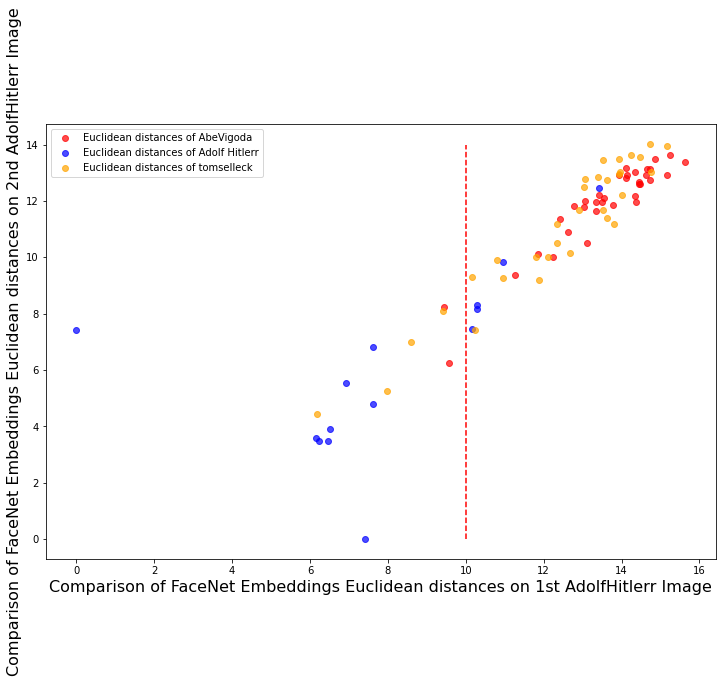

In [ ]:
fig = plt.figure(figsize=(12,8))

plt.scatter(adolf_embeddings[:, 14:][0, stream_sample['name'] == 'AbeVigoda'], adolf_embeddings[:, 14:][1, stream_sample['name'] == 'AbeVigoda'], c='red', label='Euclidean distances of AbeVigoda', alpha=0.7)
plt.scatter(adolf_embeddings[0, :14], adolf_embeddings[1, :14], c='blue', label='Euclidean distances of Adolf Hitlerr', alpha=0.7)
plt.scatter(adolf_embeddings[:, 14:][0, stream_sample['name'] == 'tomselleck'], adolf_embeddings[:, 14:][1, stream_sample['name'] == 'tomselleck'], c='orange', label='Euclidean distances of tomselleck', alpha=0.7)
plt.vlines(x=10, ymax=14, ymin=0, linestyles='dashed', color='red')
plt.xlabel("Comparison of FaceNet Embeddings Euclidean distances on 1st AdolfHitlerr Image", fontsize=16)
plt.ylabel("Comparison of FaceNet Embeddings Euclidean distances on 2nd AdolfHitlerr Image", fontsize=16)
plt.legend()
plt.show()

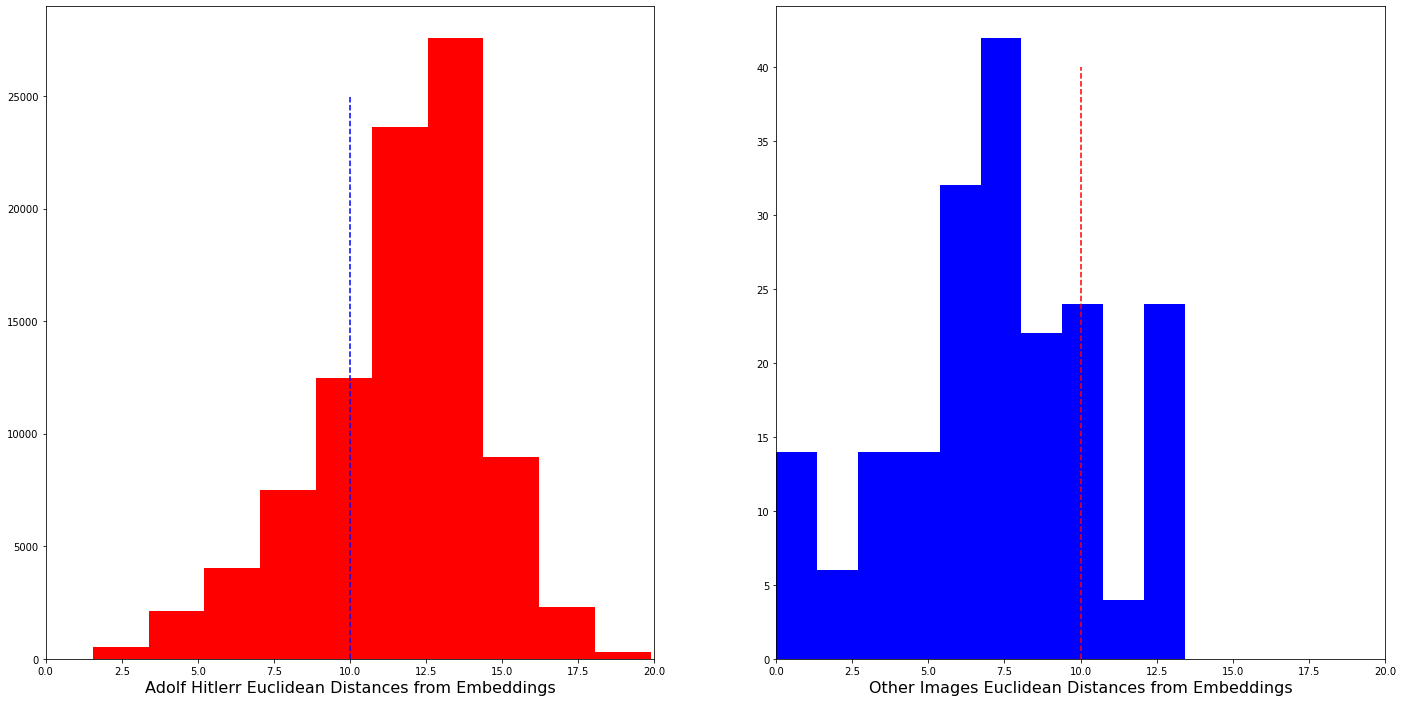

In [ ]:
fig = plt.figure(figsize=(24,12))
plt.subplot(1,2,1)
plt.hist(adolf_embeddings[:14, 14:].flatten(), color='red')
plt.xlabel("Adolf Hitlerr Euclidean Distances from Embeddings", fontsize=16)
plt.vlines(x=10, ymax=25000, ymin=0, linestyles='dashed', color='blue')
plt.xlim((0,20))
plt.subplot(1,2,2)
plt.hist(adolf_embeddings[:14, :14].flatten(), color='blue')
plt.xlabel("Other Images Euclidean Distances from Embeddings", fontsize=16)
plt.vlines(x=10, ymax=40, ymin=0, linestyles='dashed', color='red')
plt.xlim((0,20))
plt.show()

## Accuracy / F1 / Recall

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

y_test = [0]*adolf_embeddings[:14, :14].flatten().shape[0] + [1]*adolf_embeddings[:14, 14:].flatten().shape[0]

def get_labels(cutoff):
    similar = adolf_embeddings[:14, :14].flatten()
    dissimilar = adolf_embeddings[:14, 14:].flatten()
    y_pred_similar = [0 if value < cutoff else 1 for value in similar]
    y_pred_dissimilar = [0 if value < cutoff else 1 for value in dissimilar]

    return y_pred_similar + y_pred_dissimilar

accuracy = []
recall = []
precision = []
f1 = []
roc_auc = []

for cutoff in tqdm(np.arange(4, 12, 0.1)):
    y_pred = get_labels(cutoff)
    Accuracy = accuracy_score(y_test, y_pred)
    Recall = recall_score(y_test, y_pred, average='weighted')
    Precision = precision_score(y_test, y_pred, average='weighted')
    F1_Score = f1_score(y_test, y_pred, average='weighted')
    ROC_AUC_Score = roc_auc_score(y_test, y_pred, average='weighted')
    
    accuracy.append(Accuracy)
    recall.append(Recall)
    precision.append(Precision)
    f1.append(F1_Score)
    roc_auc.append(ROC_AUC_Score)


100%|██████████| 80/80 [01:06<00:00,  1.21it/s]


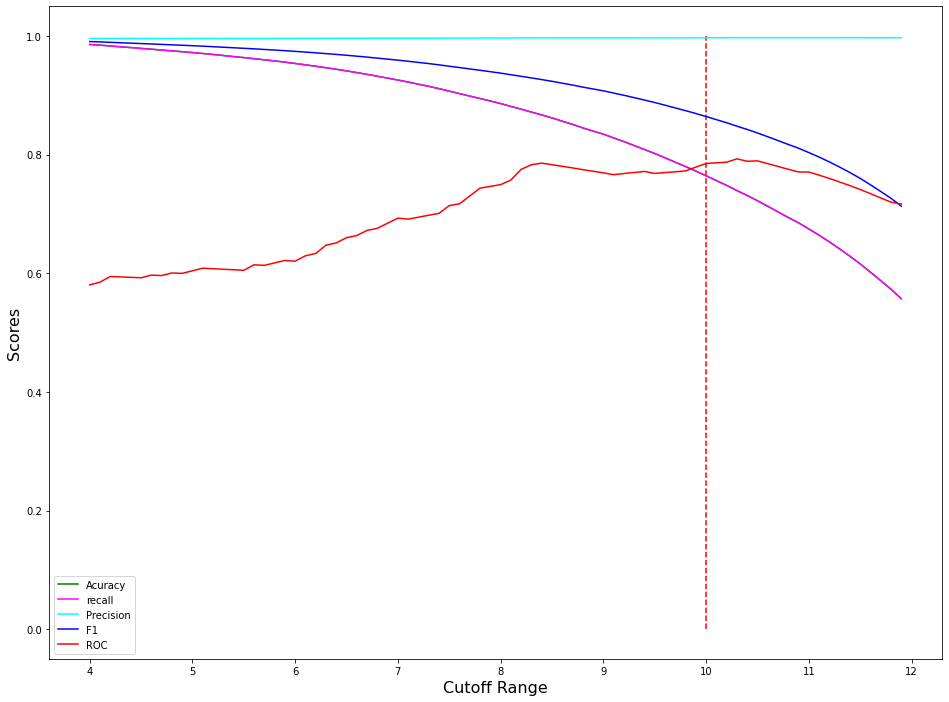

In [ ]:
plt.figure(figsize=(16,12))
plt.plot(np.arange(4, 12, 0.1), accuracy, color='green', label='Acuracy')
plt.plot(np.arange(4, 12, 0.1), recall, color='magenta', label='recall')
plt.plot(np.arange(4, 12, 0.1), precision, color='cyan', label='Precision')
plt.plot(np.arange(4, 12, 0.1), f1, color='blue', label='F1')
plt.plot(np.arange(4, 12, 0.1), roc_auc, color='red', label='ROC')
plt.vlines(x=10, ymax=1.0, ymin=0.0, linestyles='dashed', colors='red')
plt.xlabel("Cutoff Range", fontsize=16)
plt.ylabel("Scores", fontsize=16)
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

print("""Evaluation Metrics for Non-Augmented Test Set using Model Quantization:
Accuracy: \t {accuracy},
Recall: \t {recall}, 
Precision: \t {precision},
F1_Score: \t {f1}, 
ROC-AUC-Score: \t {roc_auc},
confusion_matrix: \n {confusion_matrix}
""".format(accuracy=accuracy_score(y_test, get_labels(np.arange(4, 12, 0.1)[np.argmax(roc_auc)])), 
           recall=recall_score(y_test, get_labels(np.arange(4, 12, 0.1)[np.argmax(roc_auc)]), average='weighted'),
           precision=precision_score(y_test, get_labels(np.arange(4, 12, 0.1)[np.argmax(roc_auc)]), average='weighted'), 
           f1=f1_score(y_test, get_labels(np.arange(4, 12, 0.1)[np.argmax(roc_auc)]), average='weighted'),
           roc_auc=roc_auc_score(y_test, get_labels(np.arange(4, 12, 0.1)[np.argmax(roc_auc)]), average='weighted'), 
           confusion_matrix=confusion_matrix(y_test, get_labels(np.arange(4, 12, 0.1)[np.argmax(roc_auc)]))))

Evaluation Metrics for Non-Augmented Test Set using Model Quantization:
Accuracy: 	 0.7395273060012945,
Recall: 	 0.7395273060012945, 
Precision: 	 0.9973756873112103,
F1_Score: 	 0.8481144980836252, 
ROC-AUC-Score: 	 0.7931153203413821,
confusion_matrix: 
 [[  166    30]
 [23312 66106]]



In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

def euclidean_distance(y_first, y_second):
  distance = tf.norm(y_first - y_second, ord=2)
  return distance.numpy()

def exponential_cosine_similarity(y_first, y_second):
  e = tf.keras.metrics.CosineSimilarity()(y_first, y_second)

  return e.numpy()

def load_image(image_path):
  image = cv2.imread(image_path, cv2.IMREAD_COLOR)
  image = cv2.resize(image, (72,72))
  return tf.convert_to_tensor(l2_normalize(prewhiten(image)).reshape(-1,72,72,3))

established_sample = metadata_agedb.loc[metadata_agedb['name'] == 'AdolfHitlerr']

stream_sample = metadata_agedb.loc[metadata_agedb['name'] != "AdolfHitlerr"]

new_dataframe = pd.concat([established_sample, stream_sample], axis=0)

embeddings_transformers = []

images = []
for i in tqdm(range(len(established_sample) + len(stream_sample))):
  images.append(load_image(os.path.join(DATADIR, "AgeDB", "AgeDB", new_dataframe['filename'].iloc[i])))
  if (i+1) % 320 == 0:
    embeddings_transformers.append(new_model(np.stack(images).reshape(-1,72,72,3)))
    images = []

embeddings_transformers.append(new_model(np.stack(images).reshape(-1,72,72,3)))

100%|██████████| 6401/6401 [00:48<00:00, 132.78it/s]


In [ ]:
embeddings_transformer_distances = euclidean_distances(tf.concat(embeddings_transformers, axis=0).numpy())

In [ ]:
adolf_embeddings_transformer = embeddings_transformer_distances[:len(established_sample)]

In [ ]:
adolf_embeddings_transformer.shape

(14, 6401)

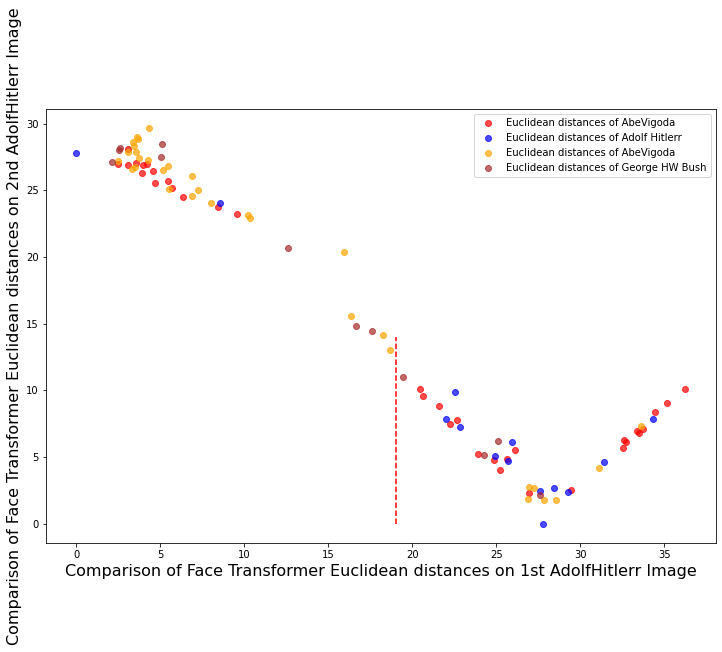

In [ ]:
fig = plt.figure(figsize=(12,8))

plt.scatter(adolf_embeddings_transformer[:, 14:][0, stream_sample['name'] == 'AbeVigoda'], adolf_embeddings_transformer[:, 14:][1, stream_sample['name'] == 'AbeVigoda'], c='red', label='Euclidean distances of AbeVigoda', alpha=0.7)
plt.scatter(adolf_embeddings_transformer[0, :14], adolf_embeddings_transformer[1, :14], c='blue', label='Euclidean distances of Adolf Hitlerr', alpha=0.7)
plt.scatter(adolf_embeddings_transformer[:, 14:][0, stream_sample['name'] == 'tomselleck'], adolf_embeddings_transformer[:, 14:][1, stream_sample['name'] == 'tomselleck'], c='orange', label='Euclidean distances of AbeVigoda', alpha=0.7)
plt.scatter(adolf_embeddings_transformer[:, 14:][0, stream_sample['name'] == 'GeorgeHWBush'], adolf_embeddings_transformer[:, 14:][1, stream_sample['name'] == 'GeorgeHWBush'], c='brown', label='Euclidean distances of George HW Bush', alpha=0.7)
plt.vlines(x=19, ymax=14, ymin=0, linestyles='dashed', color='red')
plt.xlabel("Comparison of Face Transformer Euclidean distances on 1st AdolfHitlerr Image", fontsize=16)
plt.ylabel("Comparison of Face Transformer Euclidean distances on 2nd AdolfHitlerr Image", fontsize=16)
plt.legend()
plt.show()

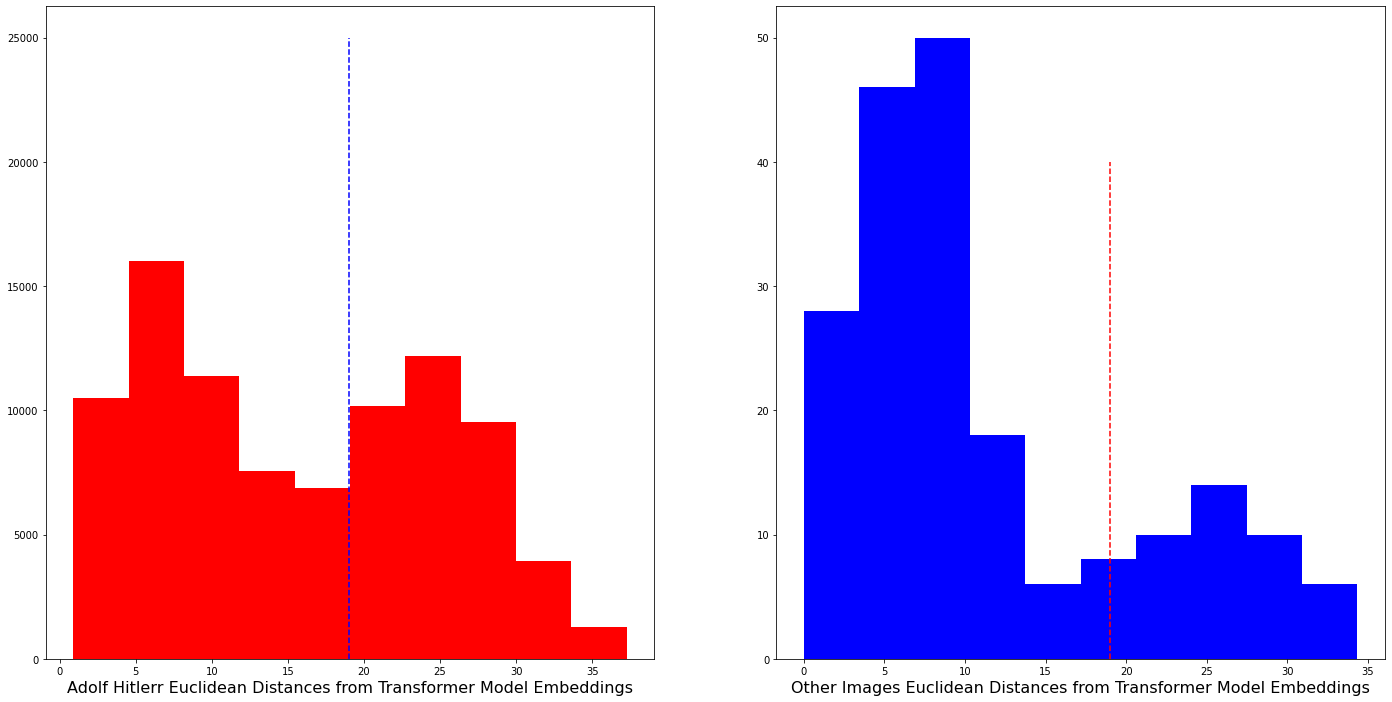

In [ ]:
fig = plt.figure(figsize=(24,12))
plt.subplot(1,2,1)
plt.hist(adolf_embeddings_transformer[:14, 14:].flatten(), color='red')
plt.xlabel("Adolf Hitlerr Euclidean Distances from Transformer Model Embeddings", fontsize=16)
plt.vlines(x=19, ymax=25000, ymin=0, linestyles='dashed', color='blue')
plt.subplot(1,2,2)
plt.hist(adolf_embeddings_transformer[:14, :14].flatten(), color='blue')
plt.xlabel("Other Images Euclidean Distances from Transformer Model Embeddings", fontsize=16)
plt.vlines(x=19, ymax=40, ymin=0, linestyles='dashed', color='red')
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

y_test = [0]*adolf_embeddings_transformer[:14, :14].flatten().shape[0] + [1]*adolf_embeddings_transformer[:14, 14:].flatten().shape[0]

def get_labels(cutoff):
    similar = adolf_embeddings_transformer[:14, :14].flatten()
    dissimilar = adolf_embeddings_transformer[:14, 14:].flatten()
    y_pred_similar = [0 if value < cutoff else 1 for value in similar]
    y_pred_dissimilar = [0 if value < cutoff else 1 for value in dissimilar]

    return y_pred_similar + y_pred_dissimilar

accuracy = []
recall = []
precision = []
f1 = []
roc_auc = []

for cutoff in tqdm(np.arange(10, 25, 0.1)):
    y_pred = get_labels(cutoff)
    Accuracy = accuracy_score(y_test, y_pred)
    Recall = recall_score(y_test, y_pred, average='weighted')
    Precision = precision_score(y_test, y_pred, average='weighted')
    F1_Score = f1_score(y_test, y_pred, average='weighted')
    ROC_AUC_Score = roc_auc_score(y_test, y_pred, average='weighted')
    
    accuracy.append(Accuracy)
    recall.append(Recall)
    precision.append(Precision)
    f1.append(F1_Score)
    roc_auc.append(ROC_AUC_Score)


100%|██████████| 150/150 [01:28<00:00,  1.70it/s]


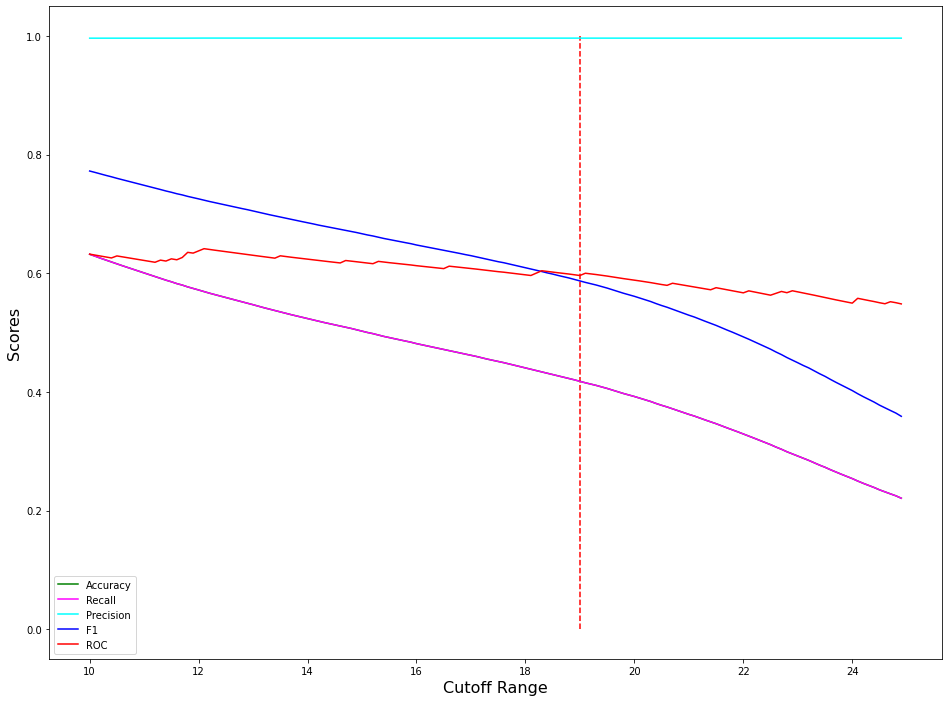

In [ ]:
plt.figure(figsize=(16,12))
plt.plot(np.arange(10, 25, 0.1), accuracy, color='green', label='Accuracy')
plt.plot(np.arange(10, 25, 0.1), recall, color='magenta', label='Recall')
plt.plot(np.arange(10, 25, 0.1), precision, color='cyan', label='Precision')
plt.plot(np.arange(10, 25, 0.1), f1, color='blue', label='F1')
plt.plot(np.arange(10, 25, 0.1), roc_auc, color='red', label='ROC')
plt.vlines(x=19, ymax=1.0, ymin=0.0, linestyles='dashed', colors='red')
plt.xlabel("Cutoff Range", fontsize=16)
plt.ylabel("Scores", fontsize=16)
plt.legend()
plt.show()

In [ ]:
np.arange(10, 25, 0.1)[np.argmax(roc_auc)]

12.099999999999993

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

print("""Evaluation Metrics for Non-Augmented Test Set using Model Quantization:
Accuracy: \t {accuracy},
Recall: \t {recall}, 
Precision: \t {precision},
F1_Score: \t {f1}, 
ROC-AUC-Score: \t {roc_auc},
confusion_matrix: \n {confusion_matrix}
""".format(accuracy=accuracy_score(y_test, get_labels(np.arange(10, 25, 0.1)[np.argmax(roc_auc)])), 
           recall=recall_score(y_test, get_labels(np.arange(10, 25, 0.1)[np.argmax(roc_auc)]), average='weighted'),
           precision=precision_score(y_test, get_labels(np.arange(10, 25, 0.1)[np.argmax(roc_auc)]), average='weighted'), 
           f1=f1_score(y_test, get_labels(np.arange(10, 25, 0.1)[np.argmax(roc_auc)]), average='weighted'),
           roc_auc=roc_auc_score(y_test, get_labels(np.arange(10, 25, 0.1)[np.argmax(roc_auc)]), average='weighted'), 
           confusion_matrix=confusion_matrix(y_test, get_labels(np.arange(10, 25, 0.1)[np.argmax(roc_auc)]))))

Evaluation Metrics for Non-Augmented Test Set using Model Quantization:
Accuracy: 	 0.5691744593478697,
Recall: 	 0.5691744593478697, 
Precision: 	 0.9967234397018607,
F1_Score: 	 0.7233269636343815, 
ROC-AUC-Score: 	 0.6415710483347871,
confusion_matrix: 
 [[  140    56]
 [38552 50866]]



In [ ]:
np.unique(stream_sample['name'])

array(['AbeVigoda', 'AlCorley', 'AlKapone', 'AlPacino', 'AlainDelon',
       'AlanRickman', 'AlanYoung', 'AlbertCamus', 'AlbertSchweitzer',
       'AlexanderGrahamBell', 'AndreMarieAmpКre', 'AndreasPapantreou',
       'AnthonyAndrews', 'AnthonyHopkins', 'ArmandAssante', 'BenGazzara',
       'BerryGordy', 'BertrandRussell', 'BillMurray', 'BillNighy',
       'BobDylan', 'BobHope', 'Bono', 'BrianDennehy', 'BruceWillis',
       'BurtReynolds', 'CarlMarx', 'CarlSagan', 'CarlosSantana',
       'CaryGrant', 'CharlesDarwin', 'CharlesGrodin', 'CharlieSheen',
       'ChevyChase', 'ChuckNorris', 'ClarkGable', 'ClaudeLВviStrauss',
       'ClaudeRich', 'ClerkMaxwell', 'ClintEastwood', 'ClintWalker',
       'ConradHilton', 'DanaAndrews', 'DannyDeVito', 'DavidMcCallum',
       'DavidSarnoff', 'DenzelWashington', 'DerekJacobi', 'DickVanDyke',
       'DickieMoore', 'DirkBogarde', 'DonJohnson', 'DustinHoffman',
       'EdHarris', 'EdwardFox', 'EdwardTeller', 'Einstain', 'ElVenizelos',
       'EliWallach

After 100 epochs, the ViT model achieves around 55% accuracy and
82% top-5 accuracy on the test data. These are not competitive results on the CIFAR-100 dataset,
as a ResNet50V2 trained from scratch on the same data can achieve 67% accuracy.

Note that the state of the art results reported in the
[paper](https://arxiv.org/abs/2010.11929) are achieved by pre-training the ViT model using
the JFT-300M dataset, then fine-tuning it on the target dataset. To improve the model quality
without pre-training, you can try to train the model for more epochs, use a larger number of
Transformer layers, resize the input images, change the patch size, or increase the projection dimensions. 
Besides, as mentioned in the paper, the quality of the model is affected not only by architecture choices, 
but also by parameters such as the learning rate schedule, optimizer, weight decay, etc.
In practice, it's recommended to fine-tune a ViT model
that was pre-trained using a large, high-resolution dataset.

In [ ]:
s = '-1, 2, 3'
tup = tuple(s)

In [ ]:
tup

('-', '1', ',', ' ', '2', ',', ' ', '3')